<a href="https://colab.research.google.com/github/maximum4645/ImageClassification_Animals-10/blob/main/exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
import urllib.request
import zipfile

# Data

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
# Download Animals-10 dataset using Kaggle API
data_dir = './Animals-10'
if not os.path.exists(data_dir):
    print("Downloading Animals-10 dataset...")
    !kaggle datasets download -d alessiocorrado99/animals10 -p .
    print("Extracting dataset...")
    !unzip -q animals10.zip -d ./Animals-10
    os.remove("animals10.zip")
    print("Download and extraction complete.")

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 98% 574M/586M [00:02<00:00, 290MB/s]
100% 586M/586M [00:02<00:00, 289MB/s]
Extracting dataset...
Download and extraction complete.


In [4]:
from torchvision.transforms.functional import adjust_sharpness
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations for normalization and data augmentation
train_transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BICUBIC),  # Better interpolation
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),         # Sharpen image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),            # Add color variation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BICUBIC),  # Match training resolution
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),         # Sharpen test images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Path to dataset
data_dir = './Animals-10/raw-img'

# Load the dataset with no transformations for splitting
dataset = ImageFolder(root=data_dir)

# Split into training and testing indices
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(
    list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets
)

# Apply separate transformations for train and test sets
train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

# Update transformations for train and test datasets
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform

# DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Define class labels
classes = dataset.classes
print("Classes:", classes)

# Print dataset sizes
print(f"Train dataset size: {len(train_set)}")
print(f"Test dataset size: {len(test_set)}")

Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Train dataset size: 20943
Test dataset size: 5236


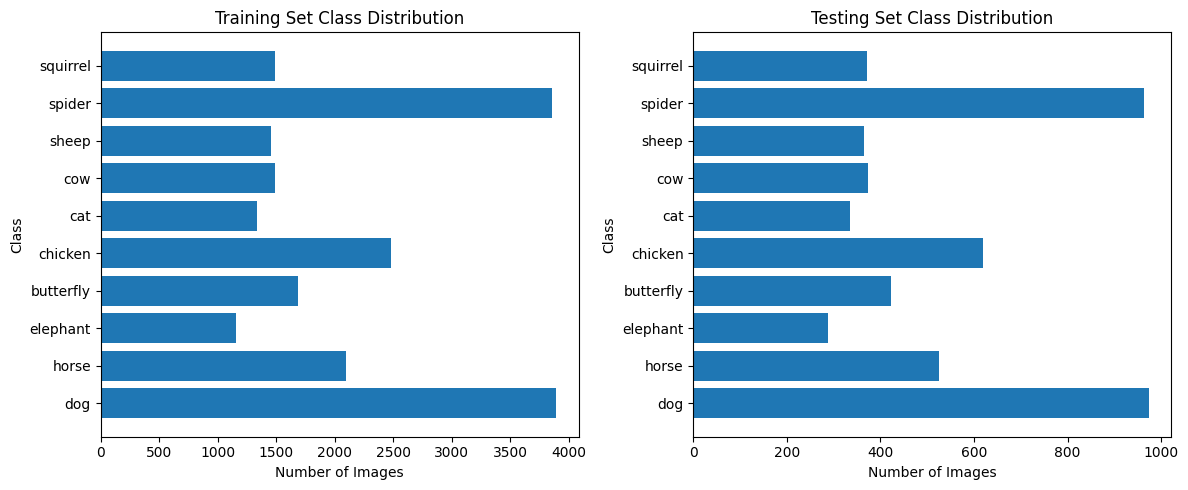

In [5]:
# Calculate class distributions
train_counter = Counter([dataset.targets[i] for i in train_idx])
test_counter = Counter([dataset.targets[i] for i in test_idx])

train_labels = list(train_counter.keys())
train_values = list(train_counter.values())

test_labels = list(test_counter.keys())
test_values = list(test_counter.values())

# Translation dictionary
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

# Translate class labels to English
english_classes = [translate[class_name] for class_name in classes]

# Plot the distributions with horizontal bars
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
ax[0].barh(train_labels, train_values, tick_label=[english_classes[i] for i in train_labels])
ax[0].set_title("Training Set Class Distribution")
ax[0].set_ylabel("Class")
ax[0].set_xlabel("Number of Images")

# Testing set distribution
ax[1].barh(test_labels, test_values, tick_label=[english_classes[i] for i in test_labels])
ax[1].set_title("Testing Set Class Distribution")
ax[1].set_ylabel("Class")
ax[1].set_xlabel("Number of Images")

plt.tight_layout()
plt.show()


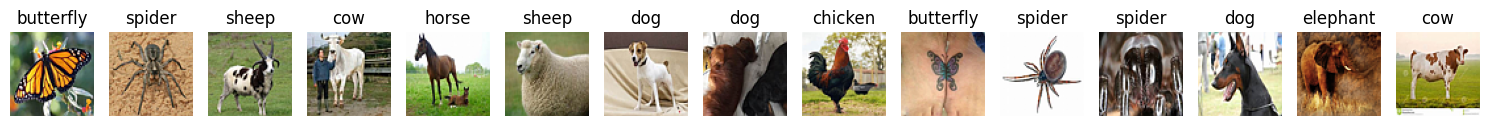

In [6]:
# Function to display images with labels
def imshow_with_labels(images, labels, classes):
    images = images / 2 + 0.5  # Unnormalize
    npimg = images.numpy()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax.set_title(classes[labels[i].item()])  # Convert tensor to index and map to English
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first n images with labels
n = 15  # Display fewer images for readability
imshow_with_labels(images[:n], labels[:n], english_classes)


# Model

In [7]:
from torchvision.models import resnet18, mobilenet_v2, efficientnet_b0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define ResNet-18
resnet18_model = resnet18(pretrained=True)
for param in resnet18_model.parameters():
    param.requires_grad = False  # Freeze all layers
# Unfreeze the last two residual blocks (layer3 and layer4)
for param in resnet18_model.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
# Modify the fully connected (FC) layer for 10 classes
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 10)
resnet18_model.fc.requires_grad = True  # Ensure the final layer is trainable
resnet18_model = resnet18_model.to(device)

# Define MobileNet_v2
mobilenet_v2_model = mobilenet_v2(pretrained=True)
for param in mobilenet_v2_model.features.parameters():
    param.requires_grad = False  # Freeze all layers in the features section
# Unfreeze the last two inverted residual blocks
for param in mobilenet_v2_model.features[-12:].parameters():  # Adjusted for two blocks
    param.requires_grad = True
# Modify the classifier for 10 classes
mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, 10)
mobilenet_v2_model.classifier[1].requires_grad = True
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Define EfficientNet_B0
efficientnet_b0_model = efficientnet_b0(pretrained=True)
for param in efficientnet_b0_model.parameters():
    param.requires_grad = False  # Freeze all layers
# Unfreeze the last two convolutional blocks
for param in efficientnet_b0_model.features[-2:].parameters():
    param.requires_grad = True
# Modify the classifier for 10 classes
efficientnet_b0_model.classifier[1] = nn.Linear(efficientnet_b0_model.classifier[1].in_features, 10)
efficientnet_b0_model.classifier[1].requires_grad = True
efficientnet_b0_model = efficientnet_b0_model.to(device)

# Print a summary of one model (optional)
print(resnet18_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.4MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Before training

ResNet-18 Metrics:
Accuracy: 10.22%
Classification Report:
               precision    recall  f1-score   support

         dog       0.08      0.05      0.06       973
       horse       0.21      0.56      0.30       525
    elephant       0.02      0.05      0.03       289
   butterfly       0.07      0.18      0.10       422
     chicken       0.07      0.04      0.05       620
         cat       0.05      0.00      0.01       334
         cow       0.05      0.08      0.06       373
       sheep       0.05      0.03      0.04       364
      spider       0.15      0.04      0.06       964
    squirrel       0.08      0.01      0.02       372

    accuracy                           0.10      5236
   macro avg       0.08      0.10      0.07      5236
weighted avg       0.09      0.10      0.08      5236



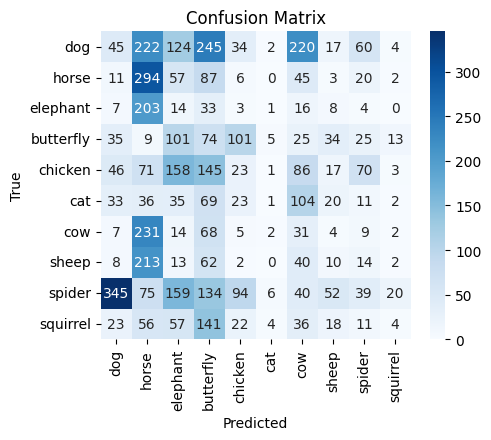


MobileNet_v2 Metrics:
Accuracy: 7.01%
Classification Report:
               precision    recall  f1-score   support

         dog       0.23      0.03      0.05       973
       horse       0.00      0.00      0.00       525
    elephant       0.11      0.66      0.18       289
   butterfly       0.00      0.00      0.00       422
     chicken       0.18      0.01      0.01       620
         cat       0.07      0.01      0.02       334
         cow       0.13      0.07      0.09       373
       sheep       0.03      0.27      0.06       364
      spider       0.33      0.01      0.02       964
    squirrel       0.13      0.02      0.03       372

    accuracy                           0.07      5236
   macro avg       0.12      0.11      0.05      5236
weighted avg       0.16      0.07      0.04      5236



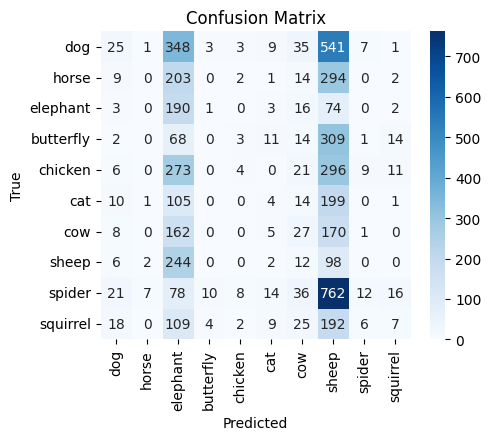


EfficientNet_B0 Metrics:
Accuracy: 8.80%
Classification Report:
               precision    recall  f1-score   support

         dog       0.16      0.08      0.11       973
       horse       0.08      0.02      0.04       525
    elephant       0.07      0.13      0.09       289
   butterfly       0.07      0.04      0.05       422
     chicken       0.06      0.07      0.06       620
         cat       0.09      0.11      0.10       334
         cow       0.07      0.16      0.10       373
       sheep       0.08      0.08      0.08       364
      spider       0.08      0.09      0.09       964
    squirrel       0.11      0.16      0.13       372

    accuracy                           0.09      5236
   macro avg       0.09      0.09      0.09      5236
weighted avg       0.10      0.09      0.09      5236



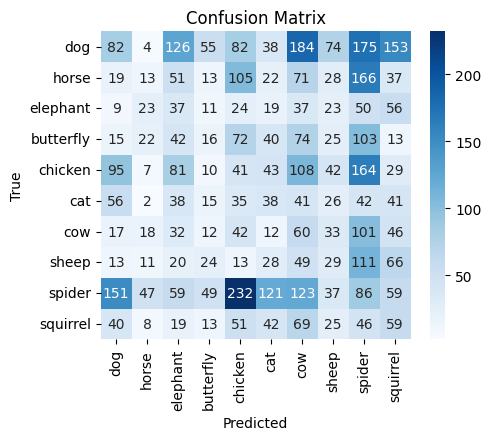

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to calculate detailed metrics
def evaluate_model(model, data_loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=2)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report, cm

# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_before, resnet18_report_before, resnet18_cm_before = evaluate_model(resnet18_model, test_loader, device, english_classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_before, mobilenet_v2_report_before, mobilenet_v2_cm_before = evaluate_model(mobilenet_v2_model, test_loader, device, english_classes)

# Evaluate EfficientNet_B0
print("\nEfficientNet_B0 Metrics:")
efficientnet_b0_accuracy_before, efficientnet_b0_report_before, efficientnet_b0_cm_before = evaluate_model(efficientnet_b0_model, test_loader, device, english_classes)


# Training

In [9]:
import torch.optim as optim
from torch.utils.data import random_split
from collections import Counter
import random
from torchvision.transforms import functional as TF

# ================== Define the Training Function ==================
def train_model(model, train_loader, val_loader=None, criterion=None, optimizer=None, device=None, epochs=20, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') if val_loader else None
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    return train_losses, val_losses if val_loader else train_losses

# ================== Split the Training Data ==================
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_idx, val_idx = random_split(range(len(train_set)), [train_size, val_size])

# Create subsets for training and validation
train_subset = torch.utils.data.Subset(train_set, train_idx)
val_subset = torch.utils.data.Subset(train_set, val_idx)

# ================== Class Balancing for Training Subset ==================
augmented_images = []
augmented_labels = []

# Count images per class
class_counts = Counter([train_set.dataset.targets[i] for i in train_idx])
max_class_count = max(class_counts.values())

# Augment underrepresented classes
for class_idx, count in class_counts.items():
    if count < max_class_count:
        diff = max_class_count - count
        print(f"Augmenting class {english_classes[class_idx]}: {count} -> {max_class_count}")

        # Get all images and their correct labels for this class
        class_images = [train_set.dataset[i] for i in train_idx if train_set.dataset.targets[i] == class_idx]

        # Apply augmentations
        for _ in range(diff):
            img, label = random.choice(class_images)  # Preserve correct label
            augmented_img = TF.rotate(img, angle=random.uniform(-15, 15))
            augmented_img = TF.hflip(augmented_img) if random.random() > 0.5 else augmented_img
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

# Combine original and augmented data for the training subset
train_dataset = [(train_set.dataset[i][0], train_set.dataset.targets[i]) for i in train_idx]
train_dataset.extend(zip(augmented_images, augmented_labels))

# ================== Create DataLoaders ==================
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

# ================== Define Common Training Settings ==================
criterion = torch.nn.CrossEntropyLoss()

# ================== Train ResNet-18 ==================
print("Training ResNet-18...")
resnet18_optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)
resnet18_train_losses, resnet18_val_losses = train_model(
    resnet18_model, train_loader, val_loader, criterion, resnet18_optimizer, device
)

# ================== Train MobileNet_v2 ==================
print("\nTraining MobileNet_v2...")
mobilenet_v2_optimizer = optim.SGD(mobilenet_v2_model.parameters(), lr=0.001, momentum=0.9)
mobilenet_v2_train_losses, mobilenet_v2_val_losses = train_model(
    mobilenet_v2_model, train_loader, val_loader, criterion, mobilenet_v2_optimizer, device
)

# ================== Train EfficientNet_B0 ==================
print("\nTraining EfficientNet_B0...")
efficientnet_b0_optimizer = optim.SGD(efficientnet_b0_model.parameters(), lr=0.001, momentum=0.9)
efficientnet_b0_train_losses, efficientnet_b0_val_losses = train_model(
    efficientnet_b0_model, train_loader, val_loader, criterion, efficientnet_b0_optimizer, device
)


Augmenting class cow: 1513 -> 3853
Augmenting class horse: 2098 -> 3853
Augmenting class butterfly: 1704 -> 3853
Augmenting class spider: 1154 -> 3853
Augmenting class cat: 1334 -> 3853
Augmenting class chicken: 2482 -> 3853
Augmenting class elephant: 1159 -> 3853
Augmenting class sheep: 1457 -> 3853
Training ResNet-18...
Epoch 1/20, Train Loss: 0.9129, Val Loss: 1.0479
Epoch 2/20, Train Loss: 0.4176, Val Loss: 0.9420
Epoch 3/20, Train Loss: 0.2254, Val Loss: 0.9270
Epoch 4/20, Train Loss: 0.1164, Val Loss: 0.9725
Epoch 5/20, Train Loss: 0.0635, Val Loss: 0.9844
Epoch 6/20, Train Loss: 0.0383, Val Loss: 1.0089
Epoch 7/20, Train Loss: 0.0246, Val Loss: 1.0352
Early stopping at epoch 8

Training MobileNet_v2...
Epoch 1/20, Train Loss: 0.8222, Val Loss: 1.0042
Epoch 2/20, Train Loss: 0.4214, Val Loss: 0.9248
Epoch 3/20, Train Loss: 0.2740, Val Loss: 0.8994
Epoch 4/20, Train Loss: 0.1866, Val Loss: 0.9089
Epoch 5/20, Train Loss: 0.1280, Val Loss: 0.9588
Epoch 6/20, Train Loss: 0.0889, Val 

# After training

ResNet-18 Metrics:
Accuracy: 88.22%
Classification Report:
               precision    recall  f1-score   support

         dog       0.90      0.97      0.93       973
       horse       0.92      0.97      0.94       525
    elephant       0.90      0.94      0.92       289
   butterfly       0.79      0.98      0.88       422
     chicken       0.91      0.98      0.94       620
         cat       0.69      0.96      0.80       334
         cow       0.95      0.94      0.94       373
       sheep       0.92      0.95      0.94       364
      spider       0.92      0.89      0.91       964
    squirrel       0.00      0.00      0.00       372

    accuracy                           0.88      5236
   macro avg       0.79      0.86      0.82      5236
weighted avg       0.83      0.88      0.85      5236



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


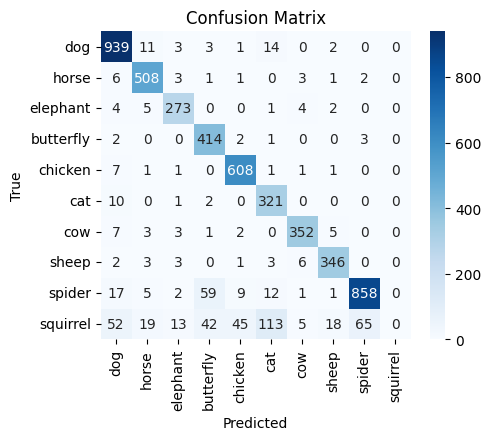


MobileNet_v2 Metrics:
Accuracy: 88.08%
Classification Report:
               precision    recall  f1-score   support

         dog       0.91      0.96      0.93       973
       horse       0.95      0.97      0.96       525
    elephant       0.90      0.96      0.93       289
   butterfly       0.78      0.99      0.87       422
     chicken       0.89      0.98      0.93       620
         cat       0.69      0.95      0.80       334
         cow       0.91      0.95      0.93       373
       sheep       0.88      0.96      0.92       364
      spider       0.93      0.88      0.90       964
    squirrel       0.00      0.00      0.00       372

    accuracy                           0.88      5236
   macro avg       0.79      0.86      0.82      5236
weighted avg       0.82      0.88      0.85      5236



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


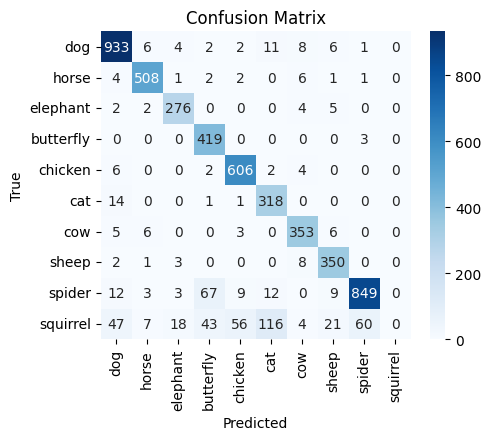


EfficientNet_B0 Metrics:
Accuracy: 77.20%
Classification Report:
               precision    recall  f1-score   support

         dog       0.80      0.78      0.79       973
       horse       0.76      0.86      0.81       525
    elephant       0.77      0.89      0.83       289
   butterfly       0.68      0.90      0.78       422
     chicken       0.82      0.86      0.84       620
         cat       0.58      0.83      0.68       334
         cow       0.77      0.80      0.79       373
       sheep       0.78      0.84      0.80       364
      spider       0.88      0.81      0.84       964
    squirrel       0.00      0.00      0.00       372

    accuracy                           0.77      5236
   macro avg       0.68      0.76      0.72      5236
weighted avg       0.73      0.77      0.75      5236



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


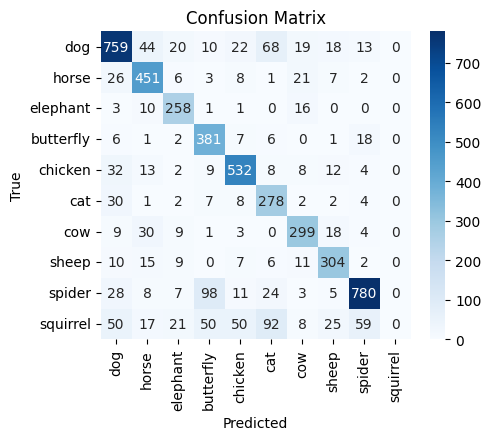

In [10]:
# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_after, resnet18_report_after, resnet18_cm_after = evaluate_model(resnet18_model, test_loader, device, english_classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_after, mobilenet_v2_report_after, mobilenet_v2_cm_after = evaluate_model(mobilenet_v2_model, test_loader, device, english_classes)

# Evaluate EfficientNet_B0
print("\nEfficientNet_B0 Metrics:")
efficientnet_b0_accuracy_after, efficientnet_b0_report_after, efficientnet_b0_cm_after = evaluate_model(efficientnet_b0_model, test_loader, device, english_classes)


In [11]:
# Store results for comparison
results = {
    "ResNet-18": {
        "Before Training": {"Accuracy": resnet18_accuracy_before},
        "After Training": {"Accuracy": resnet18_accuracy_after},
    },
    "MobileNet_v2": {
        "Before Training": {"Accuracy": mobilenet_v2_accuracy_before},
        "After Training": {"Accuracy": mobilenet_v2_accuracy_after},
    },
    "EfficientNet_B0": {
        "Before Training": {"Accuracy": efficientnet_b0_accuracy_before},
        "After Training": {"Accuracy": efficientnet_b0_accuracy_after},
    },
}

# Print the summarized results
for model, accuracy in results.items():
    print(f"\n{model} Results:")
    print(f"  Before Training Accuracy: {accuracy['Before Training']['Accuracy']:.2f}%")
    print(f"  After Training Accuracy: {accuracy['After Training']['Accuracy']:.2f}%")



ResNet-18 Results:
  Before Training Accuracy: 10.22%
  After Training Accuracy: 88.22%

MobileNet_v2 Results:
  Before Training Accuracy: 7.01%
  After Training Accuracy: 88.08%

EfficientNet_B0 Results:
  Before Training Accuracy: 8.80%
  After Training Accuracy: 77.20%


ResNet-18 Misclassifications:


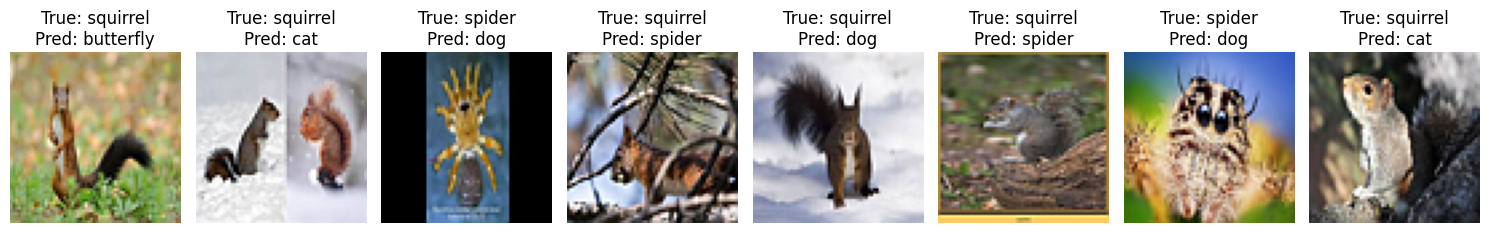

In [12]:
def visualize_misclassifications(model, data_loader, device, classes, num_images=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break

    # Handle case with fewer misclassifications
    num_to_plot = min(len(misclassified), num_images)

    # Plot misclassified images
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 5))
    if num_to_plot == 1:
        axes = [axes]  # Handle single subplot case
    for ax, (img, true_label, pred_label) in zip(axes, misclassified):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize for ResNet-18
print("ResNet-18 Misclassifications:")
visualize_misclassifications(resnet18_model, test_loader, device, english_classes, num_images=8)


In [17]:
import os
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a symbolic link for easier access
!ln -s "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Experimentation_2" /content/Experimentation_2
print("Symbolic link created: /content/Experimentation_2")

# Define the path to the Results folder
folder_path = '/content/Experimentation_2/Results'

# Create the Results folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created (or already exists) at: {folder_path}")

# Define the path for the JSON file for Version 2
json_file_path = os.path.join(folder_path, "model_results_v2.json")

# Save the results as Version 2
try:
    with open(json_file_path, "w") as f:
        json.dump(results, f, indent=4)
    print(f"Version 2 Results saved to: {json_file_path}")
except NameError:
    print("Error: The 'results' dictionary is not defined. Ensure you have results from your experiments.")


Mounted at /content/drive
Symbolic link created: /content/Experimentation_2
Folder created (or already exists) at: /content/Experimentation_2/Results
Version 2 Results saved to: /content/Experimentation_2/Results/model_results_v2.json
